<a href="https://colab.research.google.com/github/HallelWeinberg/Image-Processing/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Enhancement / Cleaning / Restoring**
In this homework we will enhance/clean/restore 8 bad images.

In [1]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2

In [2]:
# for baby:
src_baby1 = np.float32([[6, 20], [111, 20], [111, 130], [5, 130]])
src_baby2 = np.float32([[181, 5], [249, 70], [176.5, 120], [121, 51]])
src_baby3 = np.float32([[78, 162.5], [146.5, 117], [245, 160], [131.5, 244]])
dst_baby = np.float32([[0, 0], [256, 0], [256, 256], [0, 256]])


def find_transform(pointset1, pointset2):
    X = np.zeros((2 * pointset1.shape[0], 8))
    new_X = np.zeros((2 * pointset2.shape[0], 1))

    for i in range(pointset1.shape[0]):
        X[2 * i, 0] = pointset1[i, 0]
        X[2 * i, 1] = pointset1[i, 1]
        X[2 * i, 4] = 1
        X[2 * i, 6] = -pointset1[i, 0] * pointset2[i, 0]
        X[2 * i, 7] = -pointset1[i, 1] * pointset2[i, 0]
        X[2 * i + 1, 2] = pointset1[i, 0]
        X[2 * i + 1, 3] = pointset1[i, 1]
        X[2 * i + 1, 5] = 1
        X[2 * i + 1, 6] = -pointset1[i, 0] * pointset2[i, 1]
        X[2 * i + 1, 7] = -pointset1[i, 1] * pointset2[i, 1]

    for i in range(pointset1.shape[0]):
        new_X[2 * i] = pointset2[i, 0]
        new_X[2 * i + 1] = pointset2[i, 1]

    temp_T = np.matmul(np.linalg.pinv(X), new_X)
    T = np.array([[temp_T[0, 0], temp_T[1, 0], temp_T[4, 0]], [temp_T[2, 0], temp_T[3, 0], temp_T[5, 0]], [temp_T[6, 0], temp_T[7, 0], 1]])
    return T


def trasnform_image(image, T):
    Tinv = np.linalg.pinv(T)
    new_image = np.zeros((image.shape[0], image.shape[1]), dtype = np.float32)
    point = np.ones((3, 1), dtype = np.float32)
    for new_i in range(image.shape[0]):
        for new_j in range(image.shape[1]):
            point[1][0] = new_i
            point[0][0] = new_j

            original_point = np.matmul(Tinv, point)
            i = round(original_point[1][0] / original_point[2][0])
            j = round(original_point[0][0] / original_point[2][0])

            if 0 <= i <= image.shape[0] - 1 and 0 <= j <= image.shape[1] - 1:
                new_image[new_i][new_j] = image[i][j]
    return new_image


def clean_SP_noise_single(im, radius):
    noise_im = im.copy()
    clean_im = np.zeros((im.shape[0], im.shape[1]), dtype = np.float32)

    for i in range(im.shape[0]):
        for j in range(im.shape[1]):

            start_i = max(0, i - radius)
            end_i = min(im.shape[0], i + radius + 1)

            start_j = max(0, j - radius)
            end_j = min(im.shape[1], j + radius + 1)

            neighborhood = noise_im[start_i:end_i, start_j:end_j]

            clean_im[i][j] = np.median(neighborhood)

    return clean_im

def clean_SP_noise_multiple(images):
    clean_image = np.median(images, axis=0)

    return clean_image

# for watermelon:
kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])

In [3]:
def clean_baby(im):
    T1 = find_transform(src_baby1, dst_baby)
    im1 = trasnform_image(im,T1)
    im1 = clean_SP_noise_single(im1, 1)

    T2 = find_transform(src_baby2, dst_baby)
    im2 = trasnform_image(im, T2)
    im2 = clean_SP_noise_single(im2, 1)

    T3 = find_transform(src_baby3, dst_baby)
    im3 = trasnform_image(im, T3)
    im3 = clean_SP_noise_single(im3, 1)

    im1 = cv2.medianBlur(im1, 5)
    im2 = cv2.medianBlur(im2, 5)
    im3 = cv2.medianBlur(im3, 5)
    H, W = im.shape
    SP_images = np.zeros((3, H, W))
    SP_images[0, :, :] = im1
    SP_images[1, :, :] = im2
    SP_images[2, :, :] = im3
    return clean_SP_noise_multiple(SP_images)


def clean_windmill(im):
    clean_im = np.fft.fftshift(np.fft.fft2(im))
    clean_im[124,100] = 0
    clean_im[132,156] = 0
    clean_im = np.fft.ifft2(np.fft.ifftshift(clean_im))
    return abs(clean_im)


def clean_watermelon(im):
    clean_im = cv2.filter2D(im, -1, kernel_sharpening)
    return clean_im


def clean_umbrella(im):
    kernel = np.zeros(im.shape)
    kernel[0][0] = 1
    kernel[4][79] = 1

    fft_kernel = np.fft.fft2(kernel)
    fft_kernel[np.abs(fft_kernel) < 0.01] = 1
    clean_im = np.fft.fft2(im) / fft_kernel

    clean_im = 2 * abs(np.fft.ifft2(clean_im))
    return clean_im


def clean_USAflag(im):
    clean_im = im.copy()
    r = 5
    for i in range(im.shape[0]):
        for j in range(r, im.shape[1]-r):
            clean_im[i][j] = np.median(im[i, j - r : j + r + 1])
    im_stars = im[0:90, 0:146]
    clean_im[0:90, 0:146] = im_stars
    return clean_im


def clean_cups(im):
    clean_im = np.fft.fftshift(np.fft.fft2(im))
    clean_im[108:149, 108:149] = clean_im[108:149, 108:149] * 1.5
    clean_im = np.fft.ifft2(np.fft.ifftshift(clean_im))
    return abs(clean_im)


def clean_house(im):
    kernel = np.zeros(im.shape)
    kernel[0][0:10] = 1

    fft_kernel = np.fft.fft2(kernel)
    fft_kernel[np.abs(fft_kernel) < 0.01] = 1

    clean_im = np.fft.fft2(im) / fft_kernel
    clean_im = 10 * abs(np.fft.ifft2(clean_im))

    return clean_im


def clean_bears(im):
    clean_im = im.copy()

    # contrast:
    a = 255 / (np.max(clean_im) - np.min(clean_im))
    b = 255 - a * np.max(clean_im)
    clean_im = (a * clean_im + b)

    return clean_im

# Image 1:

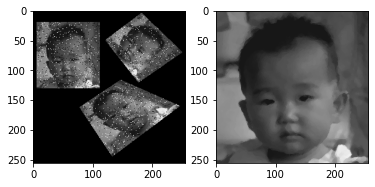

In [4]:
    im1 = cv2.imread(r'baby.tif')
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im1_clean = clean_baby(im1)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(im1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im1_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 2:

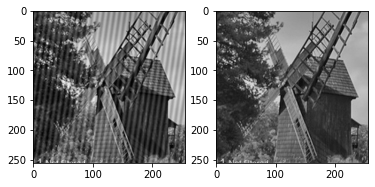

In [5]:
    im2 = cv2.imread(r'windmill.tif')
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im2_clean = clean_windmill(im2)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im2, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im2_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 3:

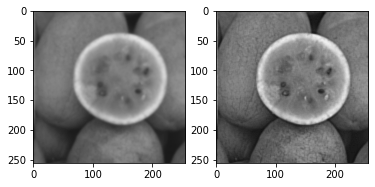

In [6]:
    im3 = cv2.imread(r'watermelon.tif')
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
    im3_clean = clean_watermelon(im3)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im3, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im3_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 4:

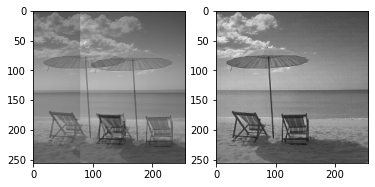

In [7]:
    im4 = cv2.imread(r'umbrella.tif')
    im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
    im4_clean = clean_umbrella(im4)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im4, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im4_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 5:

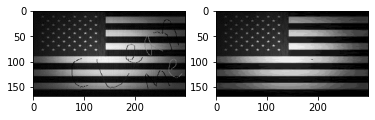

In [8]:
    im5 = cv2.imread(r'USAflag.tif')
    im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
    im5_clean = clean_USAflag(im5)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im5, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im5_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 6:

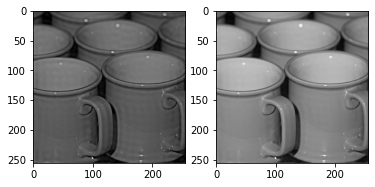

In [9]:
    im6 = cv2.imread(r'cups.tif')
    im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
    im6_clean = clean_cups(im6)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im6, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im6_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 7:

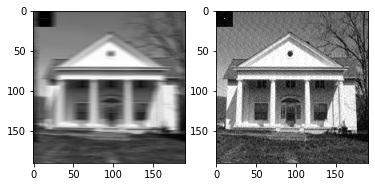

In [10]:
    im7 = cv2.imread(r'house.tif')
    im7 = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
    im7_clean = clean_house(im7)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im7, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im7_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Image 8:

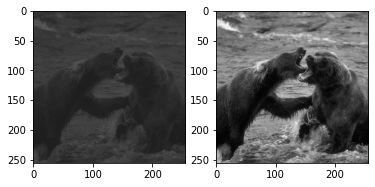

In [11]:
    im8 = cv2.imread(r'bears.tif')
    im8 = cv2.cvtColor(im8, cv2.COLOR_BGR2GRAY)
    im8_clean = clean_bears(im8)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im8, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im8_clean, cmap='gray', vmin=0, vmax=255)
    plt.show()